In [2]:
import subprocess
from dotenv import load_dotenv
import os
import sys

from model.stock_data import fetch_stock_data, preprocess_data # model package contains useful model training functions
from model.model import create_model, create_sequences
from json_manage import json_state, data_file # edit the fastapi state, data file
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from pandas import DataFrame as DF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


load_dotenv()
cwd = os.getenv("CWD")
print(cwd)

#fastapi_process = subprocess.Popen(["uvicorn", "main:app", "--reload"], cwd=cwd)
#streamlit_process = subprocess.Popen(["streamlit", "run", "streamlit/app.py"])

json_state.set_state("training")

ticker_name = "NVDA"
time_period = 31 # days used to create sliding window

# Fetch and preprocess data
try:
    print("Fetching stock data")
    data = fetch_stock_data(ticker_name)
    data = preprocess_data(data)
except:
    print("Error - stock data")
    sys.exit()

#data.plot.line(y='Close', use_index=True)
#plt.show()

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = DF(scaler.fit_transform(data), columns=data.columns)

#ic(scaled_data.head())

predictors = list(data.columns)
train = ["+1d","+7d"]

for col in train:
    predictors.remove(col)


predictors_scaled_df = scaled_data[predictors]
train_scaled_df = scaled_data[train]

print(predictors_scaled_df.head(), train_scaled_df.head())


x_train, x_test, y_train, y_test = train_test_split(np.array(predictors_scaled_df), np.array(train_scaled_df),
                                                    test_size=0.2, random_state=1)


x_train_sequences = create_sequences(x_train, time_period)
y_train_sequences = create_sequences(y_train, time_period)
x_test_sequences = create_sequences(x_test, time_period)
y_test_sequences = create_sequences(y_test, time_period)

print(x_train_sequences.shape, y_train_sequences.shape)

input_shape = x_train_sequences.shape # samples, timesteps, features

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model = create_model(input_shape)

model_info = model.fit(x_train_sequences, [y_train_sequences[:, :, 0], y_train_sequences[:, :, 1]],
                    epochs=25,
                    batch_size=32,
                    validation_split=0.2,
                    validation_data=(x_test_sequences, [y_test_sequences[:, :, 0], y_test_sequences[:, :, 1]]),
                    callbacks=[early_stopping])

model.save("stock_1,7day_model.keras")


y_test_result = model.predict(x_test_sequences)

# `y_test_result` will be a list of two arrays, each containing the predictions for one of the outputs
y_test_result_1d = y_test_result[0]  # Predictions for +1d
y_test_result_7d = y_test_result[1]  # Predictions for +7d

y_test_sequences_reduced = y_test_sequences[:, -1, :] # reduce the sequence dimension, take +1d and +7d at last index

# Calculate accuracy metrics
y_test_actual_1d = y_test_sequences_reduced[:, 0]  # Actual values for +1d from the test set
y_test_actual_7d = y_test_sequences_reduced[:, 1]  # Actual values for +7d from the test set

mse_1d = mean_squared_error(y_test_actual_1d, y_test_result_1d)
mae_1d = mean_absolute_error(y_test_actual_1d, y_test_result_1d)
r2_1d = r2_score(y_test_actual_1d, y_test_result_1d)

mse_7d = mean_squared_error(y_test_actual_7d, y_test_result_7d)
mae_7d = mean_absolute_error(y_test_actual_7d, y_test_result_7d)
r2_7d = r2_score(y_test_actual_7d, y_test_result_7d)

print(f'+1d - MSE: {mse_1d:.3e}, MAE: {mae_1d:.3e}, R2: {r2_1d:.3f}')
print(f'+7d - MSE: {mse_7d:.3e}, MAE: {mae_7d:.3e}, R2: {r2_7d:.3f}')




json_state.set_state("trained")


# pause until the processes terminate
#fastapi_process.wait()
#streamlit_process.wait()

2024-07-25 16:11:50.850871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/williamhampshire/Desktop/pycharm/fastApiProject1
Fetching stock data


/opt/anaconda3/envs/fastApiProject1/lib/python3.11/site-packages/yfinance/utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2022-07-26 00:00:00-04:00 to 2024-07-16 00:00:00-04:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    496 non-null    float64
 1   High    496 non-null    float64
 2   Low     496 non-null    float64
 3   Close   496 non-null    float64
 4   Volume  496 non-null    int64  
 5   Return  496 non-null    float64
 6   +1d     496 non-null    float64
 7   +7d     496 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 34.9 KB
                                Open       High        Low      Close  \
Date                                                                    
2022-07-26 00:00:00-04:00  16.870003  16.899970  16.459466  16.514404   
2022-07-27 00:00:00-04:00  17.012839  17.915823  16.893973  17.769987   
2022-07-28 00:00:00-04:00  17.954781  18.119595  17.420383  17.963770   
2022-07-29 00:00:00-04:00  17.792962  18.223477  17.672098  1

2024-07-25 16:11:58.846554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:11:58.849559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:11:58.851372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-07-25 16:11:59.243946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:11:59.245665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:11:59.247560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - ETA: 0s - loss: 0.1701 - output1_loss: 0.0866 - output2_loss: 0.0834 - output1_mse: 0.0866 - output2_mse: 0.0834

2024-07-25 16:12:06.357522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:12:06.359888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:12:06.362934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 8s 192ms/step - loss: 0.1701 - output1_loss: 0.0866 - output2_loss: 0.0834 - output1_mse: 0.0866 - output2_mse: 0.0834 - val_loss: 0.1518 - val_output1_loss: 0.0741 - val_output2_loss: 0.0777 - val_output1_mse: 0.0741 - val_output2_mse: 0.0777
Epoch 2/25
12/12 [==============================] - 1s 64ms/step - loss: 0.1337 - output1_loss: 0.0638 - output2_loss: 0.0699 - output1_mse: 0.0638 - output2_mse: 0.0699 - val_loss: 0.1500 - val_output1_loss: 0.0741 - val_output2_loss: 0.0759 - val_output1_mse: 0.0741 - val_output2_mse: 0.0759
Epoch 3/25
12/12 [==============================] - 1s 47ms/step - loss: 0.1317 - output1_loss: 0.0636 - output2_loss: 0.0681 - output1_mse: 0.0636 - output2_mse: 0.0681 - val_loss: 0.1499 - val_output1_loss: 0.0737 - val_output2_loss: 0.0762 - val_output1_mse: 0.0737 - val_output2_mse: 0.0762
Epoch 4/25
12/12 [==============================] - 1s 46ms/step - loss: 0.1311 - output1_loss: 0.0636 - output2_loss: 0.0675

2024-07-25 16:12:25.590510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-25 16:12:25.594154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-25 16:12:25.595966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 11ms/step
+1d - MSE: 7.850e-02, MAE: 2.259e-01, R2: 0.006
+7d - MSE: 7.999e-02, MAE: 2.288e-01, R2: 0.003


1

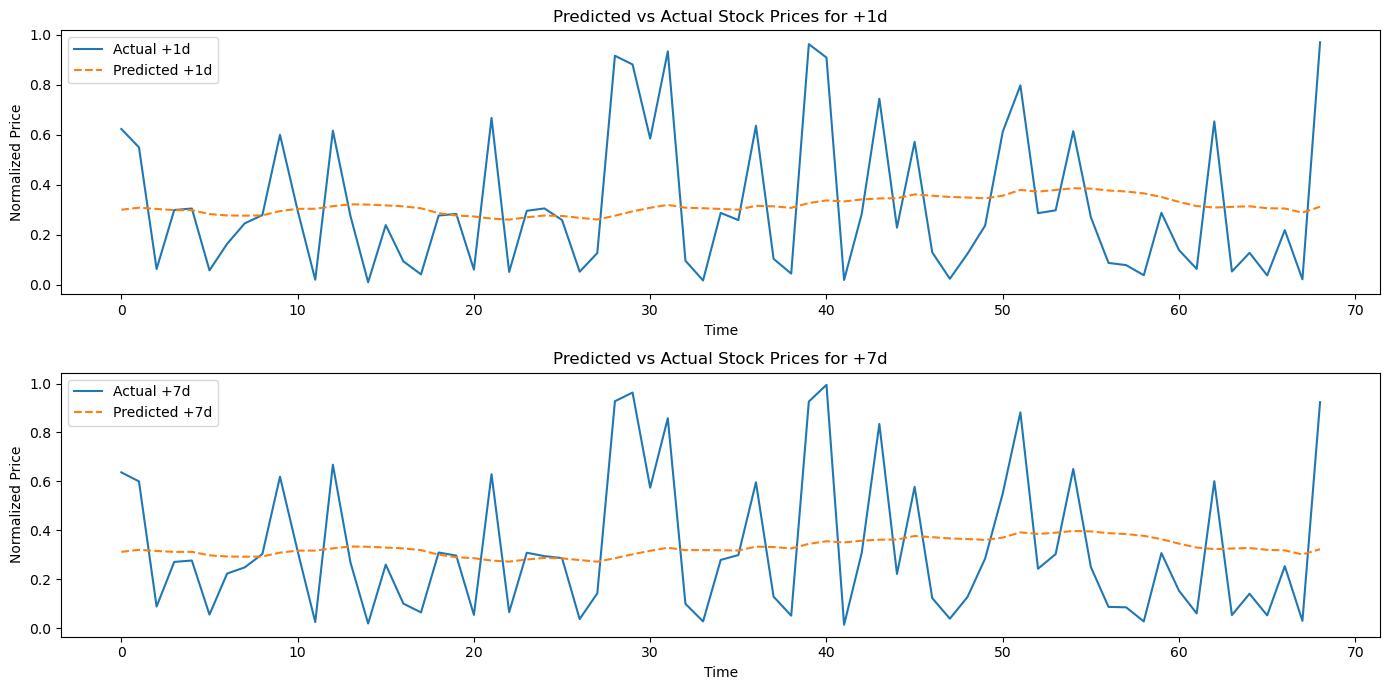

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_result and y_test_sequences_reduced are already defined


# Flatten the predictions and actual values to align them for comparison
y_test_result_1d_flat = y_test_result_1d.flatten()
y_test_result_7d_flat = y_test_result_7d.flatten()
y_test_actual_1d_flat = y_test_actual_1d.flatten()
y_test_actual_7d_flat = y_test_actual_7d.flatten()

# Plot +1d predictions vs actual values
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(y_test_actual_1d_flat, label='Actual +1d')
plt.plot(y_test_result_1d_flat, label='Predicted +1d', linestyle='--')
plt.title('Predicted vs Actual Stock Prices for +1d')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()

# Plot +7d predictions vs actual values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(y_test_actual_7d_flat, label='Actual +7d')
plt.plot(y_test_result_7d_flat, label='Predicted +7d', linestyle='--')
plt.title('Predicted vs Actual Stock Prices for +7d')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
# reconstruct actual and predicted values

actual_stock_values = [y_test_actual_1d_flat, y_test_actual_7d_flat]

predicted_stock_values = [y_test_result_1d_flat, y_test_result_7d_flat]

print(np.array(actual_stock_values).shape, np.array(predicted_stock_values).shape)

from json_manage import data_file
from pandas import DataFrame as DF

data_file.write(np.array(actual_stock_values), np.array(predicted_stock_values))

recalled_test = DF(data_file.read())
recalled_test.info()
print(recalled_test.head(10))



(2, 69) (2, 69)
real_list and prediction_list type():
<class 'list'> <class 'list'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2 non-null      object
 1   1       2 non-null      object
dtypes: object(2)
memory usage: 164.0+ bytes
                                                   0  \
0  [0.623693881050055, 0.5504301033067241, 0.0637...   
1  [0.3009522259235382, 0.3090992867946625, 0.304...   

                                                   1  
0  [0.6366388886933418, 0.5997979253933424, 0.087...  
1  [0.3117246627807617, 0.31997591257095337, 0.31...  
